# Phosphorous Predictors in the Upper Snake-Rock Water Shed, Idaho Magic Valley
### Demetrious Lloyd
### College of IT, Western Governors University, Salt Lake City, Utah
#### Disclaimer: This is a rudimentary analysis reflecting my work as a student at Western Governors University. The publicly available data sets used in these models do not represent the research performed by any government agency.

## A. Introduction

### Research Question
**Research Question:** : Given the explanatory variables provided, can a logistic regression model be developed to predict when the concentration of phosphorous will exceed its maximum allowable threshold of 0.075 ppm?

---

<img src="Phosphorus_SystemModel.jpg" alt="drawing" width="1000"/><sup>1</sup>

Phosphorous is an critical nutrient in regards to sustaining life as it comprises over 9% of all RNA and DNA by weight<sup>2</sup>. For the purposes of the USDA (US Department of Agriculture), this analysis will be focused on the environmentally harmful effects of phosphorous as a fertilizer. When phosphorous is added to soil, the runoff from watering crops can cause algae to grow en masse.<sup>1</sup> The bacteria and other microorganisms that feed off of the algae create low-oxygen environments that often lead to the death of local fish and other species.<sup>1</sup>.

CEAP, the Conservation Effects Assessment Project is a project led by the U.S. Department of Agriculture (USDA) – Natural Resources Conservation Service (NCRS)<sup>3</sup>. The watershed studies performed by CEAP inspect water quality, availability, and soil concerns throughout the nation.<sup>3</sup> Though multiple study sites exist, this analysis will inspect the CEAP data located at the location: Upper Snake River and Rock Creek, Idaho. The water path locations measured by CEAP originate from the snowmelt from South Hills of Southern-Central Idaho and discharge into the Snake River, the largest local water source of the Snake River Basin. The CEAP data delivery system, STEWARDS<sup>4</sup> reveals that this location collects flow rate data, electrical conductivity (EC), total suspended solid (TSS) measurements and specific chemical concentrations (Table 1). 

**Table 1**

Measured Soil Compounds and Their Atomic Symbols

|Atom/Molecule | Atomic Symbol|
|---|---|
|Aluminum | Al|
|Calcium | Ca|
|Chloride | Cl<sup>-</sup>|
|Iron | Fe|
|Potassium | K|
|Magnesium | Mg|
|Manganese | Mn|
|Sodium | Na|
|Ammonia | NH4<sup>+</sup>|
|Nitrate | NO3<sup>-</sup>|
|Phosphorous | P|
|Sulfur | S|
|Zinc | Zn|

It should be noted that soil particles are often negatively charged<sup>5</sup>. Nitrates and phosphorous, in its negatively charged form phosphate \( PO<sub>4</sub><sup>3-</sup> \) are repelled by soil and are more likely to be dissolved in water.

##### **Hypothesis Testing:**

**Null Hypothesis (H<sub>0</sub>):** Flow rates, electrical conductivity, suspended solids, and ion concentrations (Table 1) statistically significantly affect phosphorous threshold levels at a 0.05 alpha level.

**Alternate Hypothesis (H<sub>A</sub>):** Flow rates, electrical conductivity, suspended solids, and ion concentrations (Table 1) do not statistically significantly affect phosphorous threshold levels at a 0.05 alpha level.


## B. Data Collection

The zip files "IDUSR_Basin Discharge_measurement.7z"and "IDUSR_Basin Water Quality_measurement.7z" were used to collect the data sets: "IDUSR_Basin_SmplFlowVol.csv" and "IDUSR_Basin_WaterQuality.csv". These data sets are publicly available on a server provided by the USDA at https://www.nrrig.mwa.ars.usda.gov/stewards/stewards.html. The file "IDUSR_Basin_SmplFlowVol.csv" contains the timestamps and flow rates in meters/second at designated canal sites in the Snake River Basin. Flat file, "IDUSR_Basin_WaterQuality.csv" contains the rest of the predictors mentioned below. These data sets were converted to data frames and merged on their matching fields: SiteID, Date, and SampleID. An additional field, P_threshold, was appended to the merged data frame containing the Boolean values True and False, where True represents sample records that surpass the threshold concentration of 0.075 ppm. 0.075 ppm is an upper threshold limit established by the Idaho Department of Environmental Quality<sup>6</sup> for phosphorous concentrations in the main Snake River.

IDUSR_Basin_SmplFlowVol.csv has 4 fields: “Site identifier”, “Date & time”, “Sample identifier”, and “Sample flow volume, water, cubic meters”. These fields represent the site location, timestamp of water collection, unique sample ID and water flow in m3/s respectively. IDUSR_Basin_Waterquality.csv contains 22 fields. They are expanded upon in Table 2. The first 3 fields of both data sets will be renamed to SiteID, Date, and SampleID respectively.

**Table 2**

Fields of the Flat File: IDUSR_Basin_Waterquality.csv

|Field | Example | Meaning/Unit |
| --- | -- | --- |
|Site identifier  | IDUSRA10  | Site location |
|Date/Time  | 5/30/2006 16:30 | Timestamp |
|Sample identifier  | A10.0032  | Unique Sample ID |
|Field method  | IDUSR_FM06  | Collection and/or treatment method |
|Nitrogen, total kjeldahl, water, milligrams per liter  | 0.32 | Total Nitrogen (ppm) |
|Phosphorus, total, water, milligrams per liter  | 0.11 | Total Phosphorous (ppm) |
|Aluminum, dissolved, water, milligrams per liter  | 0.02 | Aluminum (ppm) |
|Calcium, dissolved, water, milligrams per liter  | 44.93 | Calcium (ppm) |
|Chloride, dissolved, water, milligrams per liter  | 16.9 | Chloride (ppm) |
|Iron, dissolved, water, milligrams per liter  | 0.03 | Iron (ppm) |
|Potassium, dissolved, water, milligrams per liter  | 4.02 | Potassium (ppm) |
|Magnesium, dissolved, water, milligrams per liter  | 14.91 | Magnesium (ppm) |
|Manganese, dissolved, water, milligrams per liter  | 0 | Manganese (ppm) |

## C. Data Extraction and Preparation
### Install Necessary Packages

In [6]:
#!pip install pandas
#!pip install seaborn
#!pip install missingno
#!pip install xgboost
#!pip install tensorflow

### Python Packages

The necessary Python packages for data preparation, feature extraction and logistic regression are:

In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Data Extraction

The python `os` package was used to open the directory, or PC folder, on the local machine and load the csv files mentioned in the Section B. The `getcwd()` function was used to verify the current working directory (cwd). The pandas function `read_csv()` was used to convert the CSV files into dataframes for subsequent merging and analysis. Pandas' `.info()` method was used to observe the unique columns and data types in each data frame. Pandas' `.head()` method was used to observe the top columns in a data frame. This project will make generous use of Python `f` string matching and the new line character, `\n`, from regular expressions.

In [8]:
# change my working directory (folder)
os.chdir(r"C:\Users\raven\OneDrive - Western Governors University\D214\Task_2")
print(f'Working Directory: \n{os.getcwd()}\n\n')
# file loading
file = 'IDUSR_Basin_WaterQuality.csv'
file2 = 'IDUSR_Basin_SmplFlowVol.csv'
ceap = pd.read_csv(file)
flow = pd.read_csv(file2)
ceap.info()

Working Directory: 
C:\Users\raven\OneDrive - Western Governors University\D214\Task_2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 22 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Site identifier                                            6420 non-null   object 
 1   Date/Time                                                  6420 non-null   object 
 2   Sample identifier                                          6420 non-null   object 
 3   Field method                                               6420 non-null   object 
 4   Nitrogen, total kjeldahl, water, milligrams per liter      5933 non-null   float64
 5   Phosphorus, total, water, milligrams per liter             5733 non-null   float64
 6   Aluminum, dissolved, water, milligrams per liter           6387 non-null   float64
 7   Calcium

In [9]:
ceap.head()

,Site identifier,Date/Time,Sample identifier,Field method,"Nitrogen, total kjeldahl, water, milligrams per liter","Phosphorus, total, water, milligrams per liter","Aluminum, dissolved, water, milligrams per liter","Calcium, dissolved, water, milligrams per liter","Chloride, dissolved, water, milligrams per liter","Iron, dissolved, water, milligrams per liter",...,"Manganese, dissolved, water, milligrams per liter","Sodium, dissolved, water, milligrams per liter","Ammonia, dissolved, water, milligrams per liter","Nitrate-Nitrogen, dissolved, water, milligrams per liter","Phosphorus, dissolved, water, milligrams per liter","Sulfur, dissolved, water, milligrams per liter","Zinc, dissolved, water, milligrams per liter","Specific conductivity, water, microsiemens per centimeter","pH, water, no units","Sediment, suspended, water, milligrams per liter"
0,IDUSRA10,2005-04-19 09:10:00,A10.0001,IDUSR_FM06,0.62,0.37,0.13,36.88,42.2,0.07,...,0.0,34.82,0.00,0.00,0.12,21.93,0.01,498.0,8.52,172.57
1,IDUSRA10,2005-04-28 09:50:00,A10.0002,IDUSR_FM06,0.38,0.12,0.01,33.98,38.9,0.01,...,0.0,31.23,0.00,0.00,0.03,15.79,0.05,490.0,8.22,88.42
2,IDUSRA10,2005-05-05 09:40:00,A10.0003,IDUSR_FM06,0.29,0.08,0.01,43.94,35.8,0.01,...,0.0,30.26,0.00,0.48,0.07,16.75,0.03,509.0,8.52,516.84
3,IDUSRA10,2005-05-19 09:49:00,A10.0004,IDUSR_FM06,0.34,0.07,0.02,40.41,27.6,0.01,...,0.0,24.34,0.06,0.00,0.06,14.41,0.01,447.0,8.34,60.61
4,IDUSRA10,2005-05-26 09:36:00,A10.0005,IDUSR_FM06,0.46,0.09,0.01,39.99,29.3,0.01,...,0.0,25.72,0.00,0.00,0.04,14.25,0.00,456.0,8.49,42.95


In [10]:
flow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6181 entries, 0 to 6180
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Site identifier                          6181 non-null   object 
 1   Date & time                              6181 non-null   object 
 2   Sample identifier                        6181 non-null   object 
 3   Sample flow volume, water, cubic meters  6050 non-null   float64
dtypes: float64(1), object(3)
memory usage: 193.3+ KB


In [11]:
flow.head()

,Site identifier,Date & time,Sample identifier,"Sample flow volume, water, cubic meters"
0,"""IDUSRRCH""",2015-06-02 09:03:00,"""RCH.0205""",1299369.0
1,"""IDUSRRCH""",2015-06-09 08:58:00,"""RCH.0206""",657667.0
2,"""IDUSRRCH""",2015-06-16 09:15:00,"""RCH.0207""",237604.0
3,"""IDUSRRCH""",2015-06-23 08:00:00,"""RCH.0208""",6949.0
4,"""IDUSRRCH""",2015-11-10 10:25:00,"""RCH.0209""",55303.0


### Data Formatting
The Pandas' `.todatetime()` method was used to convert both dataframe date columns from object datatypes to the datetime64\[ns\]. Converting the timestamp strings will ensure easier merging in later steps. The `.fillna()` method was used to replace all null values with zeros. This was a necessary step to merge the dataframes. In regards to data validation, this would be appropriate for all columns except pH, specific conductivity, and total suspended solids (TSS) in water samples. These 3 fields can attain true values of 0, however the statiscal likelihood of this is unlikely. 
- pH = 0 is extremely acidic and will not occur in agricultural water samples.

- Specific Conductivity = 0 mS/cm corresponds to complete deionization of water. Samples taken from agricultural runoff will have ionic compound from the soil.

- TSS = 0 mg/L is extremely unlikely as water collection occurs after agriculutural watering over soils.

In [12]:
# Convert Dates to Date/Time Data
ceap['Date/Time'] = pd.to_datetime(ceap['Date/Time'])
flow['Date & time'] = pd.to_datetime(flow['Date & time'])
ceap['Date/Time'].head()

0   2005-04-19 09:10:00
1   2005-04-28 09:50:00
2   2005-05-05 09:40:00
3   2005-05-19 09:49:00
4   2005-05-26 09:36:00
Name: Date/Time, dtype: datetime64[ns]

In [13]:
flow['Date & time'].head()

0   2015-06-02 09:03:00
1   2015-06-09 08:58:00
2   2015-06-16 09:15:00
3   2015-06-23 08:00:00
4   2015-11-10 10:25:00
Name: Date & time, dtype: datetime64[ns]

In [14]:
# Fill NA values with zero
# Null values had no reporting
ceap.fillna(0, inplace=True)
(ceap.columns)

Index(['Site identifier', 'Date/Time', 'Sample identifier', 'Field method ',
       'Nitrogen, total kjeldahl, water, milligrams per liter',
       'Phosphorus, total, water, milligrams per liter',
       'Aluminum, dissolved, water, milligrams per liter',
       'Calcium, dissolved, water, milligrams per liter',
       'Chloride, dissolved, water, milligrams per liter',
       'Iron, dissolved, water, milligrams per liter',
       'Potassium, dissolved, water, milligrams per liter',
       'Magnesium, dissolved, water, milligrams per liter',
       'Manganese, dissolved, water, milligrams per liter',
       'Sodium, dissolved, water, milligrams per liter',
       'Ammonia, dissolved, water, milligrams per liter',
       'Nitrate-Nitrogen, dissolved, water, milligrams per liter',
       'Phosphorus, dissolved, water, milligrams per liter',
       'Sulfur, dissolved, water, milligrams per liter',
       'Zinc, dissolved, water, milligrams per liter',
       'Specific conductivity, water

In [15]:
# Fill NA values with zero
# Null values had no reporting
flow.fillna(0, inplace=True)
(flow.columns)

Index(['Site identifier', 'Date & time', 'Sample identifier',
       'Sample flow volume, water, cubic meters'],
      dtype='object')


---
Data dictionaries were created to remove spacing in column names, ensure identical naming across matching fields, and match the column names as they correspond to internal databases. `.rename()` applies the dictionary to the columns of the dataframes with the `inplace` argument applying the dictionary to the dataframe in a single line of code.

---

In [16]:
# Create data dictionary to rename columns
ceap_dict = {'Site identifier':'SiteID', 'Date/Time':'Date', 'Sample identifier':'SampleID', 'Field method ':'Field_method', 'Nitrogen, total kjeldahl, water, milligrams per liter':'N_total_ppm', 'Phosphorus, total, water, milligrams per liter':'P_total_ppm', 'Aluminum, dissolved, water, milligrams per liter':'Al_ppm', 'Calcium, dissolved, water, milligrams per liter':'Ca_ppm', 'Chloride, dissolved, water, milligrams per liter':'Cl_ppm', 'Iron, dissolved, water, milligrams per liter':'Fe_ppm', 'Potassium, dissolved, water, milligrams per liter':'K_ppm', 'Magnesium, dissolved, water, milligrams per liter':'Mg_ppm', 'Manganese, dissolved, water, milligrams per liter':'Mn_ppm', 'Sodium, dissolved, water, milligrams per liter':'Na_ppm', 'Ammonia, dissolved, water, milligrams per liter':'NH4_ppm', 'Nitrate-Nitrogen, dissolved, water, milligrams per liter':'NO3_ppm', 'Phosphorus, dissolved, water, milligrams per liter':'P_ppm', 'Sulfur, dissolved, water, milligrams per liter':'S_ppm', 'Zinc, dissolved, water, milligrams per liter':'Zn_ppm', 'Specific conductivity, water, microsiemens per centimeter':'EC_mS_cm', 'pH, water, no units':'pH', 'Sediment, suspended, water, milligrams per liter':'TSS_ppm'}
flow_dict = {"Site identifier":"SiteID", "Date & time":"Date","Sample identifier":"SampleID", "Sample flow volume, water, cubic meters":"m3_s"}

In [17]:
ceap.rename(columns = ceap_dict, inplace = True)
ceap = ceap.reindex(columns = ['SiteID', 'Date', 'SampleID', 'Field_method', 'Al_ppm', 'Ca_ppm', 'Cl_ppm', 'Fe_ppm', 'K_ppm', 'Mg_ppm', 'Mn_ppm', 'Na_ppm', 'NH4_ppm', 'NO3_ppm', 'P_ppm', 'S_ppm', 'Zn_ppm', 'EC_mS_cm', 'pH', 'TSS_ppm', 'N_total_ppm', 'P_total_ppm'])
flow.rename(columns = flow_dict, inplace = True)
#Confirm Renaming
print(f"{list(ceap.columns)}")
print(f"{list(flow.columns)}")

['SiteID', 'Date', 'SampleID', 'Field_method', 'Al_ppm', 'Ca_ppm', 'Cl_ppm', 'Fe_ppm', 'K_ppm', 'Mg_ppm', 'Mn_ppm', 'Na_ppm', 'NH4_ppm', 'NO3_ppm', 'P_ppm', 'S_ppm', 'Zn_ppm', 'EC_mS_cm', 'pH', 'TSS_ppm', 'N_total_ppm', 'P_total_ppm']
['SiteID', 'Date', 'SampleID', 'm3_s']



---
The flow dataframe containing the water flow rates at specific sites has quoatation marks around the string values in the SiteID and SampleID columns. The `.str.replace()` method was used to replace every quotation mark with a blank character. This was a critical step for merging the dataframes.

---

In [18]:
flow.head()

,SiteID,Date,SampleID,m3_s
0,"""IDUSRRCH""",2015-06-02 09:03:00,"""RCH.0205""",1299369.0
1,"""IDUSRRCH""",2015-06-09 08:58:00,"""RCH.0206""",657667.0
2,"""IDUSRRCH""",2015-06-16 09:15:00,"""RCH.0207""",237604.0
3,"""IDUSRRCH""",2015-06-23 08:00:00,"""RCH.0208""",6949.0
4,"""IDUSRRCH""",2015-11-10 10:25:00,"""RCH.0209""",55303.0


In [19]:
# Remove Quotes
flow['SiteID'] = flow['SiteID'].str.replace('\"', '', regex = True)
flow['SampleID'] = flow['SampleID'].str.replace('\"', '', regex = True)

In [20]:
flow['SiteID'].head()

0    IDUSRRCH
1    IDUSRRCH
2    IDUSRRCH
3    IDUSRRCH
4    IDUSRRCH
Name: SiteID, dtype: object


---
The ceap dataframe contains 2 phosphorous columns, total phosphorous and dissolved phosphorous. Per management's reccomendation, total phosphorous values were prioritized and replaced where dissolved phosphorous exceeded these values. The Numpy `.where()` method was used to replace all such values in total phosphorous. 2 quality checks were performed before dropping the dissolved phosphorous column in favor of total phosphorous via the Pands' `.drop()` method.

---

In [21]:
# Replace total phosphorous with dissolved where dissolved is higher
ceap['P_total_ppm'] = np.where(ceap['P_total_ppm'] < ceap['P_ppm'], ceap['P_ppm'], ceap['P_total_ppm'])

In [22]:
# confirm No dissolved P is higher
print(ceap[ceap['P_ppm']>ceap['P_total_ppm']].shape[0])
# confirm equivalence in total dataframe and transformed column
print(ceap[ceap['P_ppm'] <= ceap['P_total_ppm']].shape[0] == ceap.shape[0])
# drop the dissolved phosphorous
ceap.drop('P_ppm', axis = 1, inplace =True)
# count total records
print(ceap.shape[0])

0
True
6420


In [23]:
ceap.head()

,SiteID,Date,SampleID,Field_method,Al_ppm,Ca_ppm,Cl_ppm,Fe_ppm,K_ppm,Mg_ppm,...,Na_ppm,NH4_ppm,NO3_ppm,S_ppm,Zn_ppm,EC_mS_cm,pH,TSS_ppm,N_total_ppm,P_total_ppm
0,IDUSRA10,2005-04-19 09:10:00,A10.0001,IDUSR_FM06,0.13,36.88,42.2,0.07,7.36,18.46,...,34.82,0.00,0.00,21.93,0.01,498.0,8.52,172.57,0.62,0.37
1,IDUSRA10,2005-04-28 09:50:00,A10.0002,IDUSR_FM06,0.01,33.98,38.9,0.01,5.70,18.44,...,31.23,0.00,0.00,15.79,0.05,490.0,8.22,88.42,0.38,0.12
2,IDUSRA10,2005-05-05 09:40:00,A10.0003,IDUSR_FM06,0.01,43.94,35.8,0.01,5.92,19.62,...,30.26,0.00,0.48,16.75,0.03,509.0,8.52,516.84,0.29,0.08
3,IDUSRA10,2005-05-19 09:49:00,A10.0004,IDUSR_FM06,0.02,40.41,27.6,0.01,5.57,17.27,...,24.34,0.06,0.00,14.41,0.01,447.0,8.34,60.61,0.34,0.07
4,IDUSRA10,2005-05-26 09:36:00,A10.0005,IDUSR_FM06,0.01,39.99,29.3,0.01,5.67,17.12,...,25.72,0.00,0.00,14.25,0.00,456.0,8.49,42.95,0.46,0.09


### Data Cleaning

Data cleaning steps were taken to treat duplicates, outliers, and missing values. Fortunately, no duplicates were detected and missing values were replaced with zero above. 

#### Duplicate Check

In [24]:
# Check for duplicates across ALL records
print(ceap.duplicated().values.any() == True)
print(flow.duplicated().values.any() == True)

False
False


#### Missing Values Check

In [25]:
# Check for null values across ALL records
print(ceap.isnull().values.any() == True)
print(flow.isnull().values.any() == True)

False
False


#### Outliers

The ceap data frame has 1 more site ID than the flow rates. This means that 27 of 28 possible of the Snake River Basin site locations contain flow rate measurements. 1 site will be lost upon merging the data. Management provided the insight that site location: IDUSRTFB is no longer in service at this time. The Pandas' `.unique()` and `nunique()` methods were used to collect these insights.

##### CEAP Site ID's

In [26]:
# Unqiue values of SiteID
print(f"Unique Site ID's: {ceap['SiteID'].unique()}")
print(f"Number of Unique Values: {ceap['SiteID'].nunique()}")

Unique Site ID's: ['IDUSRA10' 'IDUSRCD' 'IDUSRDC' 'IDUSREP' 'IDUSRIC' 'IDUSRL10P'
 'IDUSRL10S' 'IDUSRL26' 'IDUSRL3' 'IDUSRL30' 'IDUSRL39' 'IDUSRL43'
 'IDUSRL49' 'IDUSRL5A' 'IDUSRMC' 'IDUSRMLA' 'IDUSRNC' 'IDUSRPC' 'IDUSRQ2'
 'IDUSRQC' 'IDUSRRCH' 'IDUSRRCP' 'IDUSRS2' 'IDUSRSC' 'IDUSRSQ' 'IDUSRTF'
 'IDUSRTFB' 'IDUSRTN']
Number of Unique Values: 28


##### Flow Site ID's

In [27]:
print(f"Unique Site ID's: {flow['SiteID'].unique()}")
print(f"Number of Unique Values: {flow['SiteID'].nunique()}")

Unique Site ID's: ['IDUSRRCH' 'IDUSRRCP' 'IDUSRCD' 'IDUSRDC' 'IDUSRIC' 'IDUSRMC' 'IDUSRMLA'
 'IDUSRNC' 'IDUSRA10' 'IDUSREP' 'IDUSRL3' 'IDUSRL30' 'IDUSRL39' 'IDUSRS2'
 'IDUSRL10P' 'IDUSRL10S' 'IDUSRL26' 'IDUSRL43' 'IDUSRL49' 'IDUSRL5A'
 'IDUSRPC' 'IDUSRQ2' 'IDUSRQC' 'IDUSRSC' 'IDUSRSQ' 'IDUSRTF' 'IDUSRTN']
Number of Unique Values: 27


##### Quantitative Variables
---
Histograms of the Quantitative Variables were plotted. While various distributions are present, the primary outliers of interest are sub-zero values. Fortunately, no such values exist. All measurements were taken on calibrated laboratory equiptment by trained professionals. Treating outliers would be equivalent to falsifying data. Additionally, the presence of zeros in the histogram distributions will be skewed due to the missing value treatment of filling null values with 0.

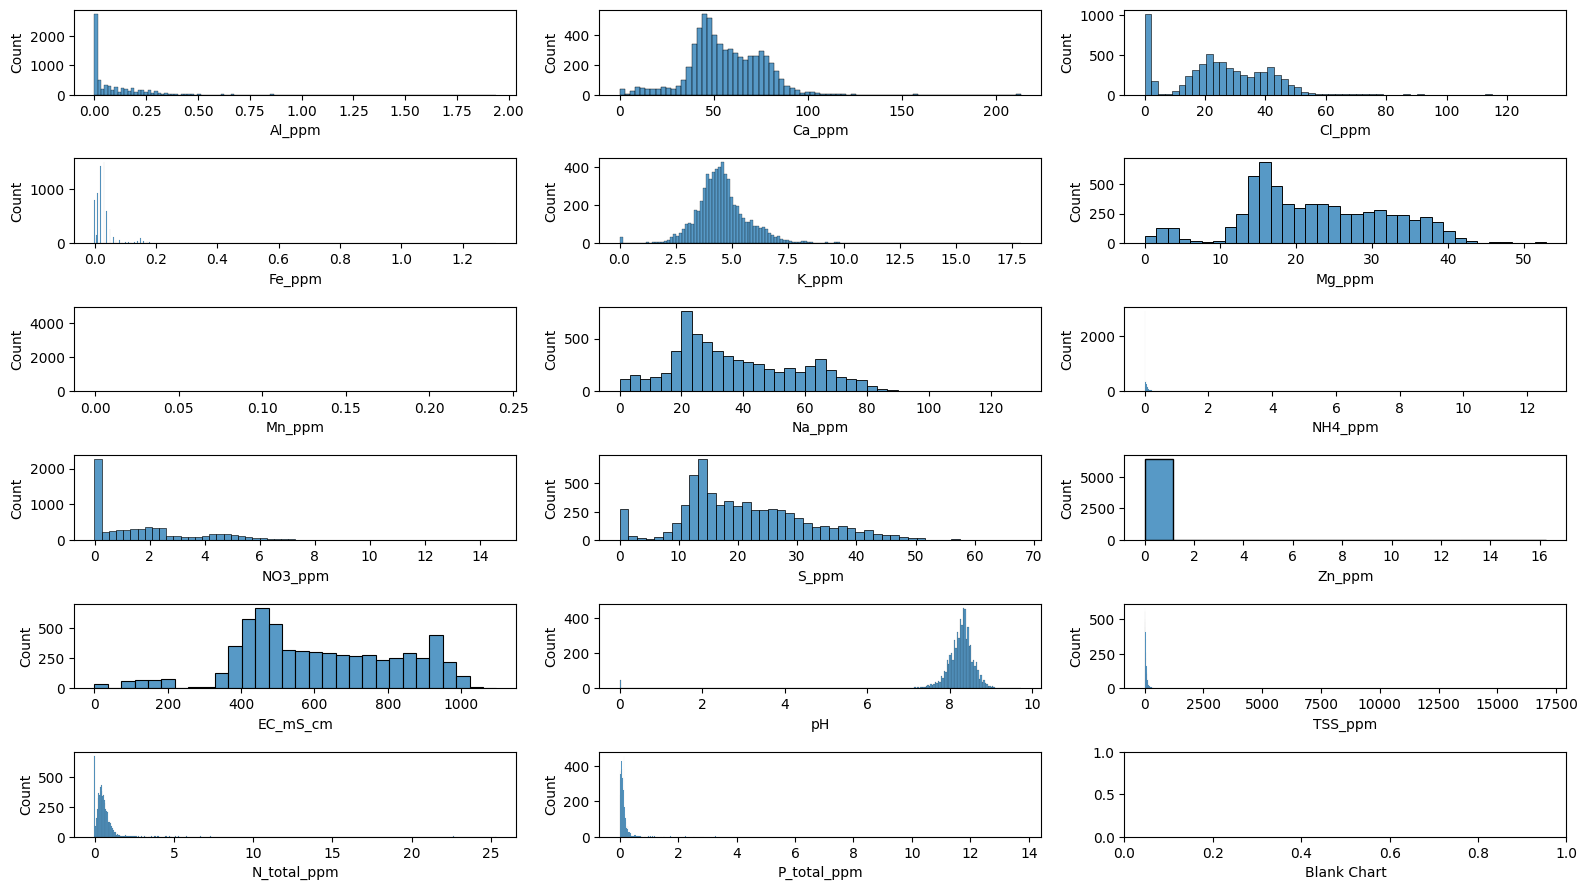

In [28]:
# histograms
fig,axs = plt.subplots(6,3, figsize= (16,9))

sns.histplot(ceap['Al_ppm'], ax =axs[0,0])
sns.histplot(ceap['Ca_ppm'], ax =axs[0,1])
sns.histplot(ceap['Cl_ppm'], ax =axs[0,2])
sns.histplot(ceap['Fe_ppm'], ax =axs[1,0])
sns.histplot(ceap['K_ppm'], ax =axs[1,1])
sns.histplot(ceap['Mg_ppm'], ax =axs[1,2])
sns.histplot(ceap['Mn_ppm'], ax =axs[2,0])
sns.histplot(ceap['Na_ppm'], ax =axs[2,1])
sns.histplot(ceap['NH4_ppm'], ax =axs[2,2])
sns.histplot(ceap['NO3_ppm'], ax =axs[3,0])
sns.histplot(ceap['S_ppm'], ax =axs[3,1])
sns.histplot(ceap['Zn_ppm'], ax =axs[3,2])
sns.histplot(ceap['EC_mS_cm'], ax =axs[4,0])
sns.histplot(ceap['pH'], ax =axs[4,1])
sns.histplot(ceap['TSS_ppm'], ax =axs[4,2])
sns.histplot(ceap['N_total_ppm'], ax =axs[5,0])
sns.histplot(ceap['P_total_ppm'], ax =axs[5,1])


axs[0,0].set_xlabel('Al_ppm')
axs[0,1].set_xlabel('Ca_ppm')
axs[0,2].set_xlabel('Cl_ppm')
axs[1,0].set_xlabel('Fe_ppm')
axs[1,1].set_xlabel('K_ppm')
axs[1,2].set_xlabel('Mg_ppm')
axs[2,0].set_xlabel('Mn_ppm')
axs[2,1].set_xlabel('Na_ppm')
axs[2,2].set_xlabel('NH4_ppm')
axs[3,0].set_xlabel('NO3_ppm')
axs[3,1].set_xlabel('S_ppm')
axs[3,2].set_xlabel('Zn_ppm')
axs[4,0].set_xlabel('EC_mS_cm')
axs[4,1].set_xlabel('pH')
axs[4,2].set_xlabel('TSS_ppm')
axs[5,0].set_xlabel('N_total_ppm')
axs[5,1].set_xlabel('P_total_ppm')
axs[5,2].set_xlabel('Blank Chart')

fig.tight_layout()


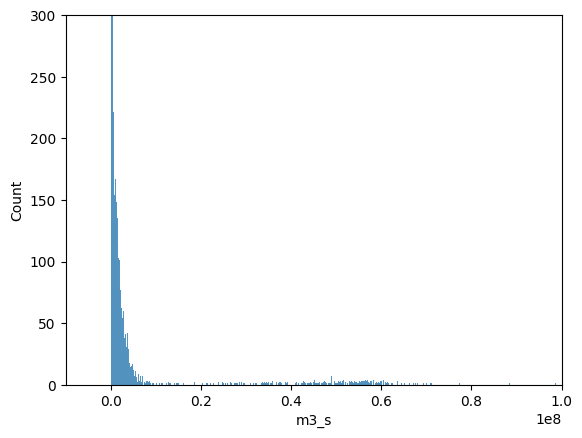

In [29]:
# Flow rates
sns.histplot(flow['m3_s'])
plt.xlim(-10000000,100000000)
plt.ylim(0, 300)
plt.show()

### Merging Data Frames

As seen in the outlier measurements, more SiteID's are present in the ceap data frame than the flow data frame. Thus it makes sense that the row count for the ceap data frame is higher. The Pandas' `.info()` method was used to validate that datatypes and columns names match across both data frames. The `.merge()` method was used to inner join both data frames on the criteria of matching SiteID, Date, and SampleID. The Date column in really a timestamp which ensures that rows are matched down to the minute. The merged dataframe, grouper,  contains less rows than either data frame, as shown by the `.shape()` method.

**Table 3**
Data Frame Row Counts 
| Data Frame | Row Count |
|---|---|
|ceap | 6420 |
|flow | 6181 |
|grouper | 5893 |

In [30]:
#Record Counts
print(f"CEAP rows:\n {ceap.shape[0]}")
print(f"CEAP flow_rate rows:\n {flow.shape[0]}")

CEAP rows:
 6420
CEAP flow_rate rows:
 6181


In [31]:
flow.info()
ceap.info()

grouper = pd.merge(flow, ceap, on = ['SiteID', 'Date', 'SampleID'], how = 'inner')
grouper.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6181 entries, 0 to 6180
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SiteID    6181 non-null   object        
 1   Date      6181 non-null   datetime64[ns]
 2   SampleID  6181 non-null   object        
 3   m3_s      6181 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 193.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SiteID        6420 non-null   object        
 1   Date          6420 non-null   datetime64[ns]
 2   SampleID      6420 non-null   object        
 3   Field_method  6420 non-null   object        
 4   Al_ppm        6420 non-null   float64       
 5   Ca_ppm        6420 non-null   float64       
 6   Cl_ppm        6420 non-null   flo

5893

#### EDA: Linear Regression on quantitative vars and P_total_ppm

In [32]:
from scipy.stats import spearmanr
quant_vars = ['m3_s', 'Al_ppm','Ca_ppm', 'Cl_ppm', 'Fe_ppm', 'K_ppm', 'Mg_ppm', 'Mn_ppm', 'Na_ppm', 'NH4_ppm', 'NO3_ppm', 'S_ppm', 'Zn_ppm', 'EC_mS_cm', 'pH', 'TSS_ppm','N_total_ppm']

for var in quant_vars:
    corr, _ = spearmanr(grouper[[var]], grouper['P_total_ppm'])
    R_square = corr**2
    print('R^2 with respect to total Phosphorous {}:\n{} {}'.format(var, R_square,'''\n'''))

R^2 with respect to total Phosphorous m3_s:
0.02086064272687907 

R^2 with respect to total Phosphorous Al_ppm:
0.030775387851836734 

R^2 with respect to total Phosphorous Ca_ppm:
0.004632224721595728 

R^2 with respect to total Phosphorous Cl_ppm:
0.019072936702025062 

R^2 with respect to total Phosphorous Fe_ppm:
0.00910923935713895 

R^2 with respect to total Phosphorous K_ppm:
0.02369607289311791 

R^2 with respect to total Phosphorous Mg_ppm:
0.006739417805612133 

R^2 with respect to total Phosphorous Mn_ppm:
0.0009991252762384358 

R^2 with respect to total Phosphorous Na_ppm:
0.005274455077168558 

R^2 with respect to total Phosphorous NH4_ppm:
5.300092903785686e-05 

R^2 with respect to total Phosphorous NO3_ppm:
0.022653170923636824 

R^2 with respect to total Phosphorous S_ppm:
0.011202215340463664 

R^2 with respect to total Phosphorous Zn_ppm:
0.001265640495227383 

R^2 with respect to total Phosphorous EC_mS_cm:
0.0064996697794633155 

R^2 with respect to total Phosphor


---
Sorting the values by Site ID and Date is a stylistic choice for readability upon exporting the dataframe as a csv. Here `.sort_values()` is the equivalent of an SQL `ORDER BY` command. Upon observing the unique value count, it is visually confirmed that 27 SiteID's are still present.

In [33]:
grouper = grouper.sort_values(by = ['SiteID', 'Date'])
# Unique Values
grouper.nunique()

SiteID            27
Date            5447
SampleID        5893
m3_s            5471
Field_method       3
Al_ppm           264
Ca_ppm          3797
Cl_ppm           776
Fe_ppm           311
K_ppm            620
Mg_ppm          2711
Mn_ppm           642
Na_ppm          3805
NH4_ppm          175
NO3_ppm          698
S_ppm           2785
Zn_ppm            98
EC_mS_cm        1370
pH               207
TSS_ppm         2716
N_total_ppm      235
P_total_ppm      110
dtype: int64

#### Qualitative Encoding of Phosphorous

---
Here a new field, P_threshold, is created. A boolean value is used to represent whether phosphorous levels are at the have reached or surpassed the threshold limit of 0.075 parts-per-million.<sup>6</sup> The pandas methods `.to_excel()` and `.tocsv()` were employed to export the clean, merged data frame as .xlsx and .csv file types. A count of the records surpassing the acceptable threshold reveals that 3,713 out of 5,893 records met this criteria.

This was observed in exploratory data analysis performed on the data set prior to modelling:

<img src="Fractions.png" alt="drawing" width="2000"/>

In all, but 2 site locations, phosphorous was above the accpetable threshold more than 50% of the time.

In [34]:
# Create Boolean for LogisticRegression
grouper['P_threshold'] = np.where(grouper['P_total_ppm'] >= 0.075, True, False)
grouper.columns

Index(['SiteID', 'Date', 'SampleID', 'm3_s', 'Field_method', 'Al_ppm',
       'Ca_ppm', 'Cl_ppm', 'Fe_ppm', 'K_ppm', 'Mg_ppm', 'Mn_ppm', 'Na_ppm',
       'NH4_ppm', 'NO3_ppm', 'S_ppm', 'Zn_ppm', 'EC_mS_cm', 'pH', 'TSS_ppm',
       'N_total_ppm', 'P_total_ppm', 'P_threshold'],
      dtype='object')

In [35]:
grouper.to_excel('ceap_public.xlsx', index = False)
grouper.to_csv('ceap_public.csv', index = False)

In [36]:
# Count Phosphorous above safe limits
grouper[grouper['P_total_ppm'] > 0.075].shape[0]

3713

### Machine Learning Model Preparation

Each site location in the Snake River Basin was one hot encoded into a boolean value using the Pandas' `.getdummies()` method. The one hot encoded values were added to the merged data frame, grouper, but not before dropping identifier columns (SampleID, Field_method, SiteID), the Date field, and the quantitative phosphorous field. The total phosphorous column would correlate too directly with the P_threshold boolean field causing colinearity. 

In [37]:
# One Hot encoding of Nominal Categorical Variables
df_one_hot = grouper['SiteID']
df_one_hot = pd.get_dummies(df_one_hot, drop_first = True)
#df_one_hot.info()

In [38]:
# Concatenate Dummy Vars
grouper = grouper.drop(columns = ['SampleID', 'Field_method', 'SiteID', 'Date', 'P_total_ppm'])
grouper = pd.concat([grouper, df_one_hot], axis = 1)
#grouper.info()

#### Set up X and y splits for Machine Learning

The target variable, y, for this analysis is P_threshold, the phosphorous threshold boolean value. The explanatory variables, X, are all the remaining quanitative fields from the merged grouper data frame as well as the one hot encoded site locations. X was normalized by subtracting the mean of all fields before dividing the difference by the standard deviation of all fields. Normalization reduces and limits variance by scaling all quantitative explanatory variables to themselves. As shown in the `X.describe()` exploratory data frame, one unit of a normalized variable corresponds to 1 standard deviation of that variable (see std = 1.00). As a result, no data field will be weighted unfairly when creating models. 

Cross validation and hold-out testing will be employed for accuracy scoring of the models. Sckit-learn's `train_test_split` equation breaks the data into training and testing data sets in for both the target and explanatory variables.<sup>7</sup> The `test_size` argument sets the argument for the fraction of testing data to be separated. Here the fraction 0.3 represents a 70% training to 30% testing split in the hold-out data sets. The `random_state` argument fixes the kernel of this jupyter notebook ensuring that the same results are repeated when rerunning this notebook and/or making edits.

In [39]:
y = grouper['P_threshold']
X = grouper.drop('P_threshold', axis = 1)
# Normalize X

X = (X-X.mean())/X.std()
X.describe()

,m3_s,Al_ppm,Ca_ppm,Cl_ppm,Fe_ppm,K_ppm,Mg_ppm,Mn_ppm,Na_ppm,NH4_ppm,...,IDUSRPC,IDUSRQ2,IDUSRQC,IDUSRRCH,IDUSRRCP,IDUSRS2,IDUSRSC,IDUSRSQ,IDUSRTF,IDUSRTN
count,5893.000000,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,...,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03,5.893000e+03
mean,0.000000,-8.681330e-17,-3.665450e-16,-2.315021e-16,-3.858369e-17,-9.645922e-18,-9.645922e-17,2.411481e-17,-1.398659e-16,-4.822961e-18,...,-7.716738e-17,-5.787553e-17,-1.929184e-17,1.929184e-17,-7.716738e-17,9.645922e-17,-1.929184e-17,-4.822961e-18,5.787553e-17,-1.929184e-17
std,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-0.275076,-6.559288e-01,-3.033255e+00,-1.605132e+00,-5.887594e-01,-3.802819e+00,-2.420443e+00,-3.911652e-01,-1.882980e+00,-3.607918e-01,...,-1.795114e-01,-1.525253e-01,-1.441627e-01,-2.122164e-01,-2.658268e-01,-2.791216e-01,-1.610457e-01,-7.839291e-02,-1.320412e-01,-1.712892e-01
25%,-0.270163,-6.559288e-01,-6.382786e-01,-5.663507e-01,-4.162538e-01,-5.678852e-01,-7.244802e-01,-2.897415e-01,-7.769299e-01,-3.308907e-01,...,-1.795114e-01,-1.525253e-01,-1.441627e-01,-2.122164e-01,-2.658268e-01,-2.791216e-01,-1.610457e-01,-7.839291e-02,-1.320412e-01,-1.712892e-01
50%,-0.253892,-4.455566e-01,-1.037241e-01,-1.489894e-02,-2.480706e-01,-9.749938e-02,-1.051498e-01,-2.897415e-01,-2.246460e-01,-2.039221e-01,...,-1.795114e-01,-1.525253e-01,-1.441627e-01,-2.122164e-01,-2.658268e-01,-2.791216e-01,-1.610457e-01,-7.839291e-02,-1.320412e-01,-1.712892e-01
75%,-0.163072,3.959324e-01,7.463848e-01,7.738054e-01,-7.988736e-02,4.554102e-01,7.913335e-01,-2.586135e-01,7.939671e-01,1.134993e-01,...,-1.795114e-01,-1.525253e-01,-1.441627e-01,-2.122164e-01,-2.658268e-01,-2.791216e-01,-1.610457e-01,-7.839291e-02,-1.320412e-01,-1.712892e-01
max,35.601992,1.294814e+01,8.480973e+00,6.923134e+00,2.144757e+01,1.098545e+01,3.229214e+00,4.918520e+01,4.531022e+00,5.902692e+01,...,5.569731e+00,6.555175e+00,6.935429e+00,4.711371e+00,3.761210e+00,3.582060e+00,6.208365e+00,1.275409e+01,7.572107e+00,5.837088e+00


In [40]:
# original train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## D. Analysis

### Feature Extraction

- Change alpha to optimzie

In [41]:
ridge = Ridge(alpha=85.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
# score is R^2
ridge.score(X_test, y_test)

0.3082648563162269

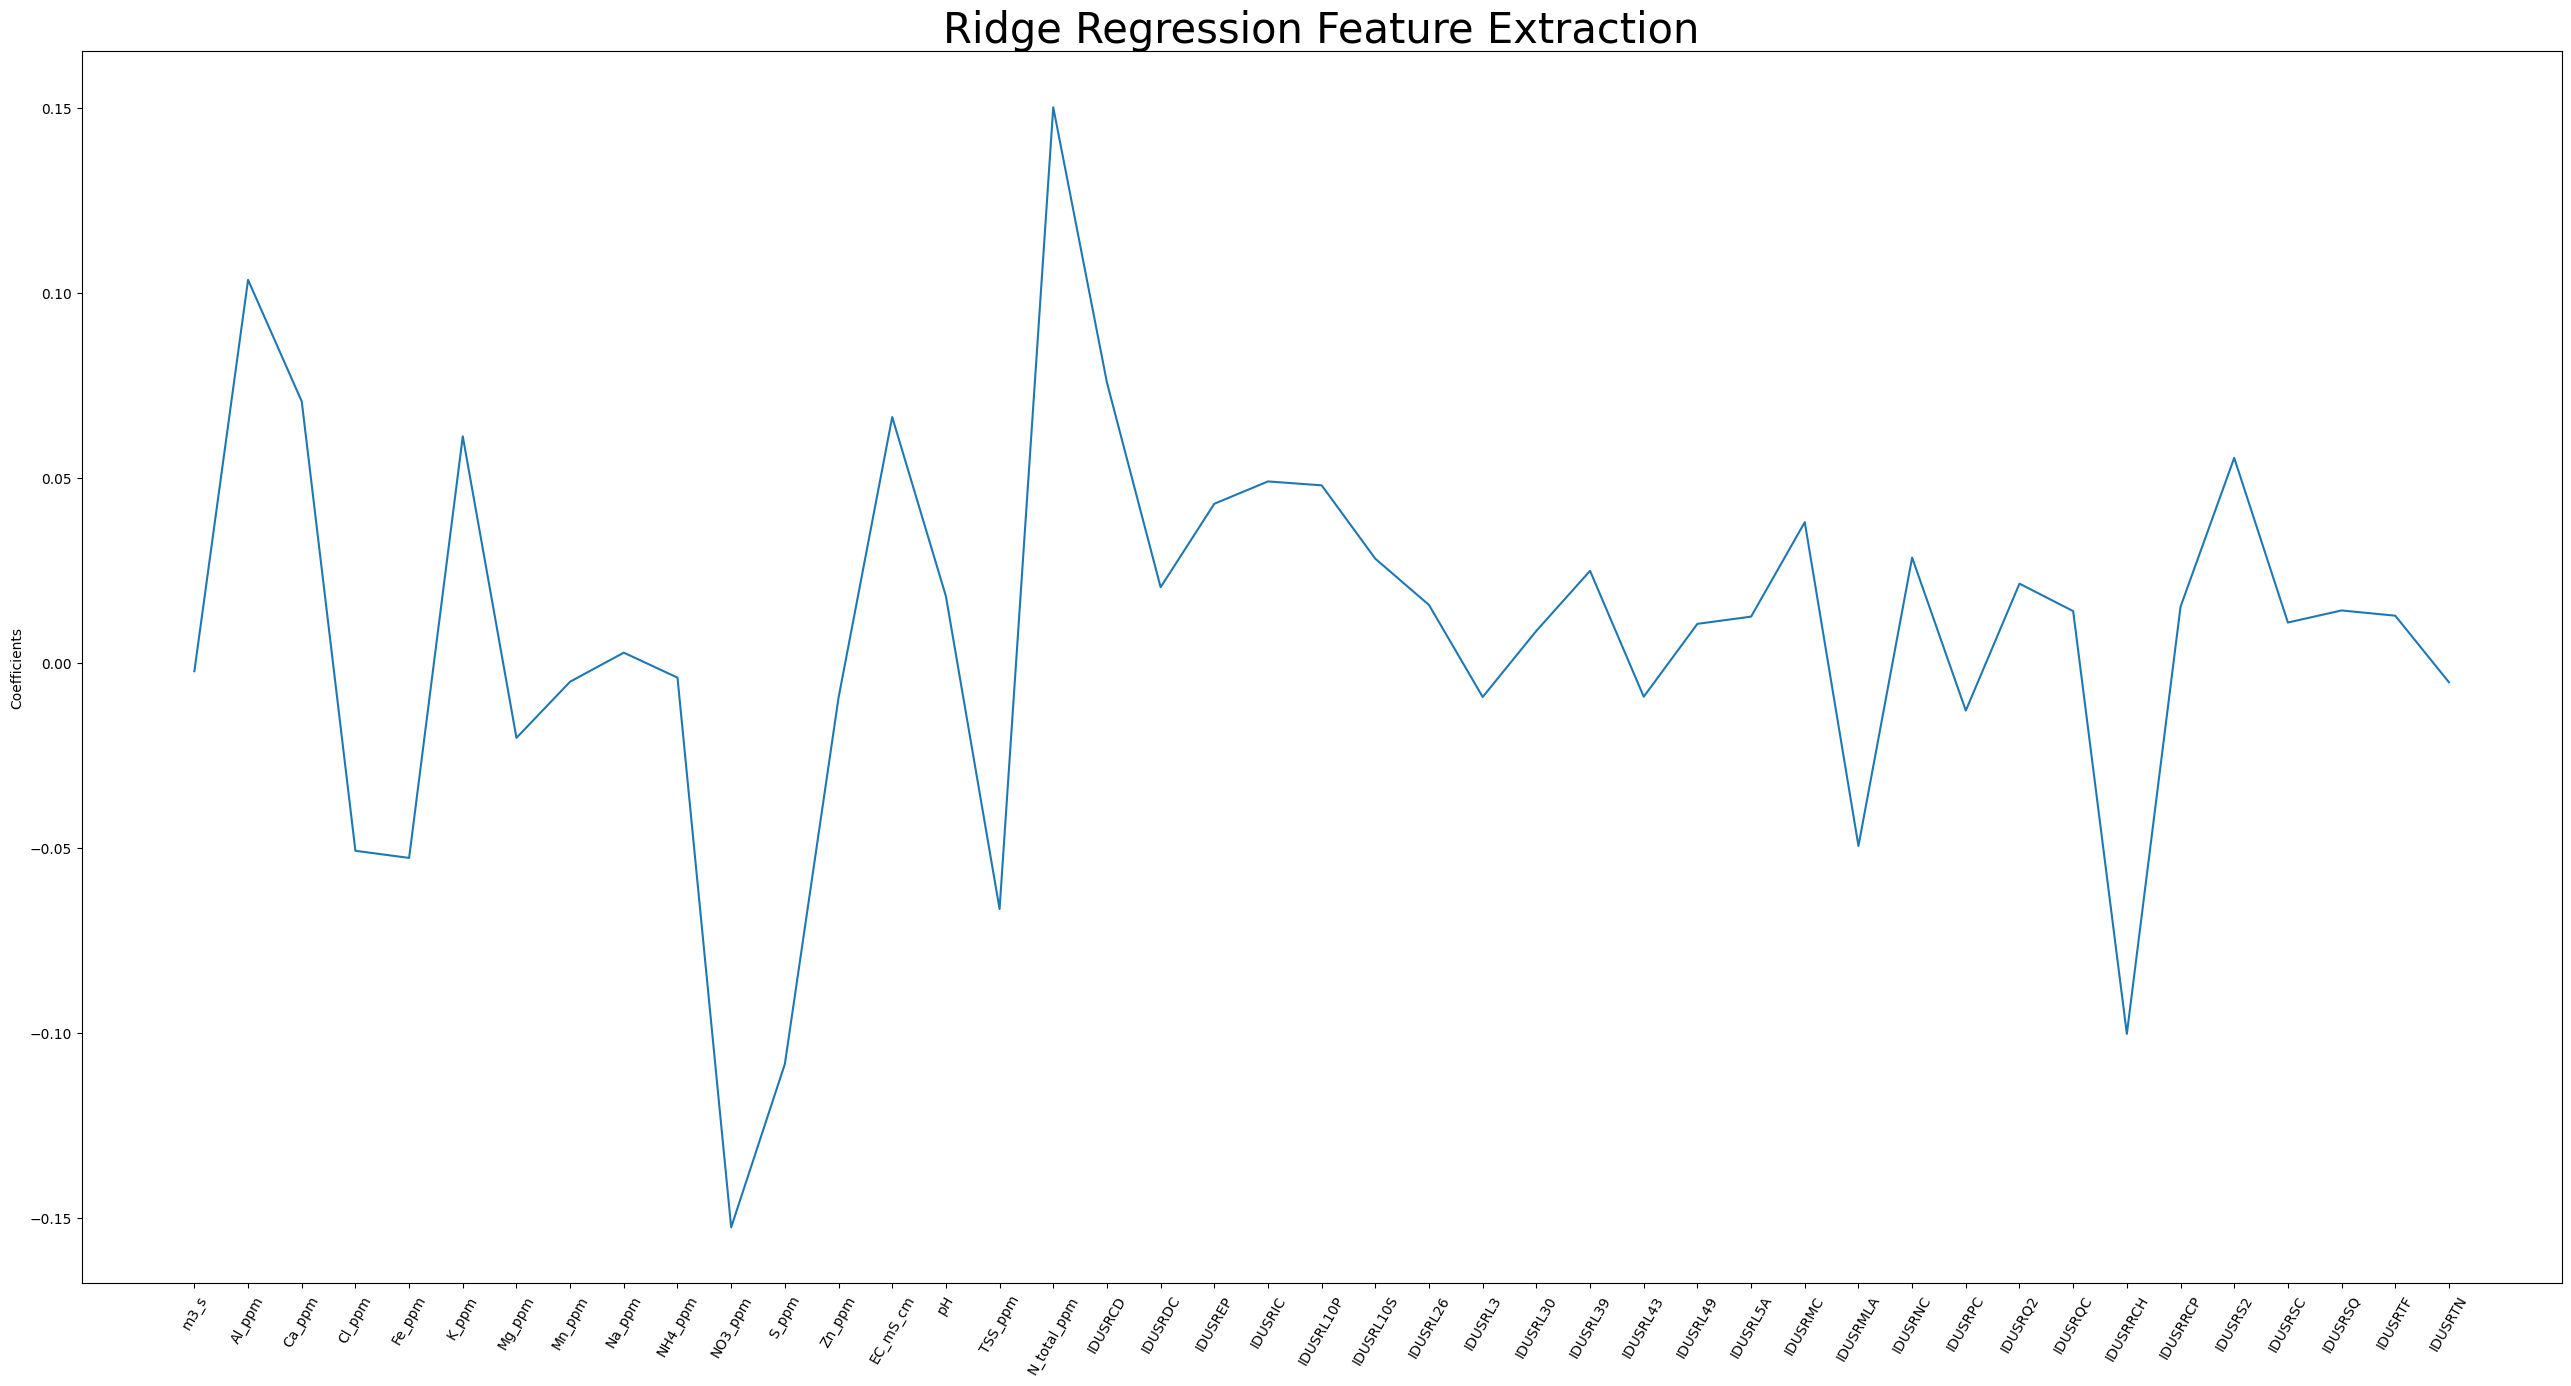

In [42]:
plt.figure(figsize=(32, 16))
_ = plt.plot(range(len(X.columns)), ridge.fit(X,y).coef_)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=60)
_ = plt.ylabel('Coefficients')
plt.title('Ridge Regression Feature Extraction', fontsize=30)
plt.show()

- Change alpha to optimize

In [43]:
lasso = Lasso(alpha=0.00001)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
# score is R^2
lasso.score(X_test, y_test)

0.20206673112994777

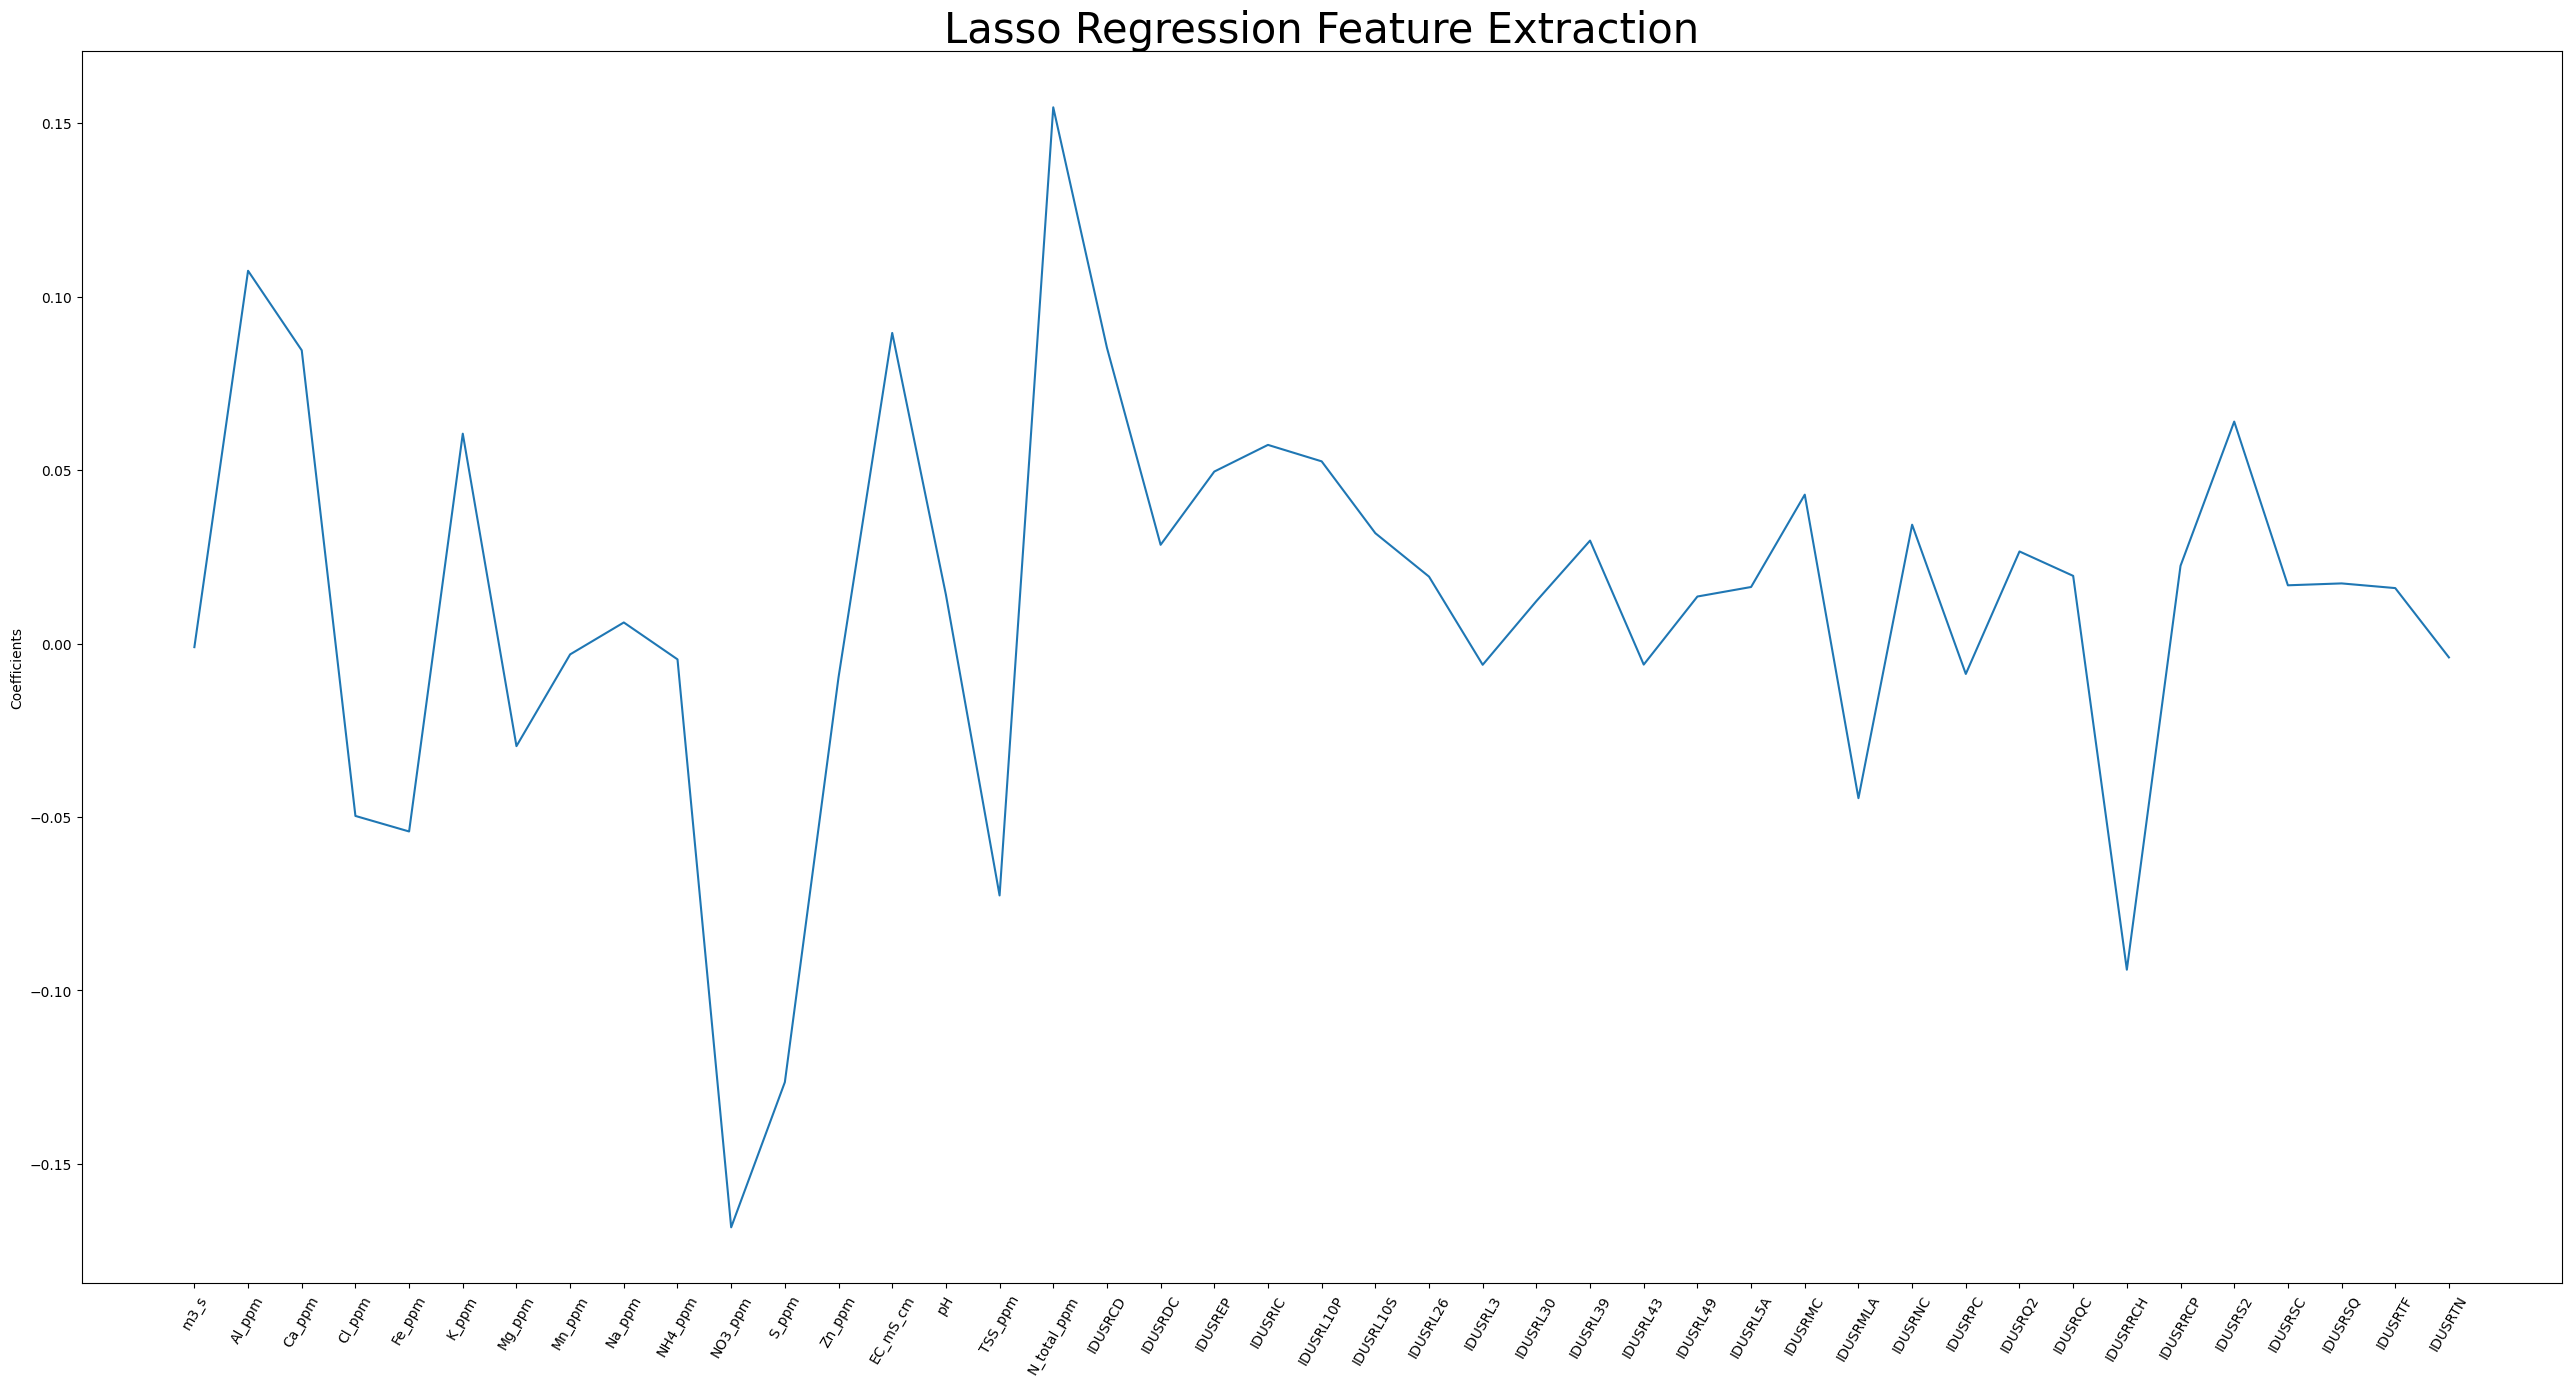

In [44]:
plt.figure(figsize=(32, 16))
_ = plt.plot(range(len(X.columns)), lasso.fit(X,y).coef_)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=60)
_ = plt.ylabel('Coefficients')
plt.title('Lasso Regression Feature Extraction', fontsize=30)
plt.show()

### Hypothesis Testing

In [45]:
site_vars = ['IDUSRCD', 'IDUSRDC', 'IDUSREP', 'IDUSRIC', 'IDUSRL10P', 'IDUSRL10S', 'IDUSRL26', 'IDUSRL3', 'IDUSRL30', 'IDUSRL39', 'IDUSRL43', 'IDUSRL49', 'IDUSRL5A', 'IDUSRMC', 'IDUSRMLA', 'IDUSRNC', 'IDUSRPC', 'IDUSRQ2', 'IDUSRQC', 'IDUSRRCH', 'IDUSRRCP', 'IDUSRS2', 'IDUSRSC', 'IDUSRSQ', 'IDUSRTF', 'IDUSRTN']
df_t = grouper.drop(site_vars, axis = 1)

In [46]:
preds = list(df_t.drop('P_threshold', axis =1).columns)

In [47]:
from scipy import stats
for var in preds:
# Assume group1 and group2 are your two groups
   t_stat, p_val = stats.ttest_ind(df_t[var], df_t['P_threshold'])

   if p_val < 0.05:
    print(f'{var}: \n {p_val} \n')
    print("The difference is statistically significant.")
   else:
      print(f'{var}')
      print("The difference is not statistically significant.")

m3_s: 
 3.50337400225235e-97 

The difference is statistically significant.
Al_ppm: 
 0.0 

The difference is statistically significant.
Ca_ppm: 
 0.0 

The difference is statistically significant.
Cl_ppm: 
 0.0 

The difference is statistically significant.
Fe_ppm: 
 0.0 

The difference is statistically significant.
K_ppm: 
 0.0 

The difference is statistically significant.
Mg_ppm: 
 0.0 

The difference is statistically significant.
Mn_ppm: 
 0.0 

The difference is statistically significant.
Na_ppm: 
 0.0 

The difference is statistically significant.
NH4_ppm: 
 0.0 

The difference is statistically significant.
NO3_ppm: 
 0.0 

The difference is statistically significant.
S_ppm: 
 0.0 

The difference is statistically significant.
Zn_ppm: 
 0.0 

The difference is statistically significant.
EC_mS_cm: 
 0.0 

The difference is statistically significant.
pH: 
 0.0 

The difference is statistically significant.
TSS_ppm: 
 1.3812002955407149e-98 

The difference is statistically sign

In [100]:
#Wilcoxon Signed Rank Test --> Mann-Whitney U non-normally distributed
from scipy.stats import mannwhitneyu
for var in preds:
  stat, p_val = mannwhitneyu(df_t[var], df_t['P_threshold'])

  if p_val < 0.05:
    print(f'{var}: \n {p_val} \n')
    print("The difference is statistically significant.")
  else:
      print(f'{var}')
      print("The difference is not statistically significant.")

m3_s: 
 0.0 

The difference is statistically significant.
Al_ppm: 
 6.072787571574438e-289 

The difference is statistically significant.
Ca_ppm: 
 0.0 

The difference is statistically significant.
Cl_ppm: 
 0.0 

The difference is statistically significant.
Fe_ppm: 
 6.23596867386079e-189 

The difference is statistically significant.
K_ppm: 
 0.0 

The difference is statistically significant.
Mg_ppm: 
 0.0 

The difference is statistically significant.
Mn_ppm: 
 0.0 

The difference is statistically significant.
Na_ppm: 
 0.0 

The difference is statistically significant.
NH4_ppm: 
 0.0 

The difference is statistically significant.
NO3_ppm: 
 3.5455977616566854e-257 

The difference is statistically significant.
S_ppm: 
 0.0 

The difference is statistically significant.
Zn_ppm: 
 0.0 

The difference is statistically significant.
EC_mS_cm: 
 0.0 

The difference is statistically significant.
pH: 
 0.0 

The difference is statistically significant.
TSS_ppm: 
 0.0 

The difference 

## All predictors of interest are statistically significant

# Multiple Logisitic Regression

In [49]:
X = X.drop(site_vars, axis = 1)
X.describe()

# Siteless train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [50]:
logreg = LogisticRegression(class_weight={0:0.5, 1:0.5}, random_state=42)
cv_results = cross_val_score(logreg, X, y, cv = 5)
print(cv_results)

[0.78456319 0.76759966 0.67514843 0.73429542 0.80220713]


In [51]:
cv_results = cross_val_score(logreg, X, y, cv = 60)

In [52]:
print(f'Mean of Cross Validation Scores: \n{np.mean(cv_results)}\n')

Mean of Cross Validation Scores: 
0.79297052154195



In [53]:
logreg.fit(X_train, y_train)

print(f'Hold-Out Testing Score: \n{logreg.score(X_test, y_test)}')

Hold-Out Testing Score: 
0.8076923076923077


In [54]:
pd.concat([pd.DataFrame(logreg.coef_).transpose(), pd.DataFrame(logreg.feature_names_in_)], axis = 1)
#list(logreg.feature_names_in_)]

,0,0
0,-0.151493,m3_s
1,0.586192,Al_ppm
2,0.267274,Ca_ppm
3,-0.330456,Cl_ppm
4,-0.568306,Fe_ppm
5,0.341569,K_ppm
6,0.309654,Mg_ppm
7,0.223778,Mn_ppm
8,-0.028762,Na_ppm
9,-0.040097,NH4_ppm


In [55]:
# Logistic Regression Intercept
logreg.intercept_

array([1.36022909])

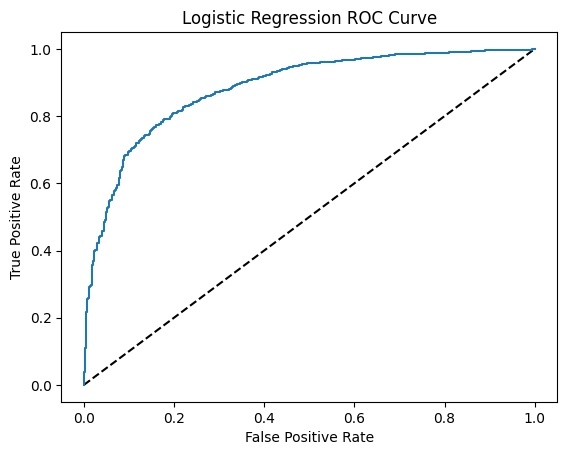

In [56]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

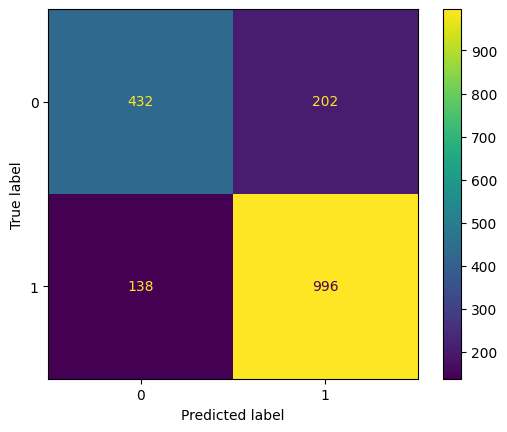

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(X_test))).plot()
plt.show()

In [58]:
# original train-test split reset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, class_weight={0:0.5, 1:0.5}, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.5, 1: 0.5}, n_estimators=10,
                       random_state=42)

In [60]:
#cross validation
cv_results = cross_val_score(rf, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
rf.score(X_test, y_test)
print(f'Test Data: \n {rf.score(X_test, y_test)}')

Cross Validation: 
0.7778567992853707
Test Data: 
 0.833710407239819


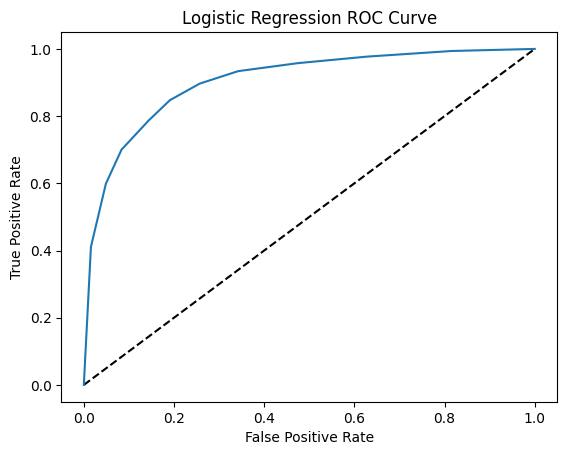

In [61]:
from sklearn.metrics import roc_curve
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

# Bagging

In [62]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0:0.5, 1:0.5}, random_state=42), n_estimators=10)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                      1: 0.5},
                                                        random_state=42))

In [63]:
#cross validation
cv_results = cross_val_score(bagging, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
bagging.score(X_test, y_test)
print(f'Test Data: \n {bagging.score(X_test, y_test)}')

Cross Validation: 
0.7822940287226
Test Data: 
 0.8359728506787331


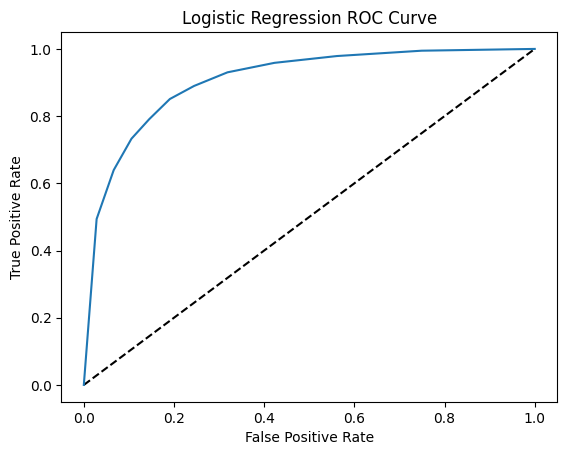

In [64]:
from sklearn.metrics import roc_curve
y_pred_prob = bagging.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

# Boosting

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0:0.5, 1:0.5}, random_state=42), n_estimators=10)
boosting.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                       1: 0.5},
                                                         random_state=42),
                   n_estimators=10)

In [66]:
#cross validation
cv_results = cross_val_score(boosting, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
boosting.score(X_test, y_test)
print(f'Test Data: \n {boosting.score(X_test, y_test)}')

Cross Validation: 
0.7322510822510822
Test Data: 
 0.7878959276018099


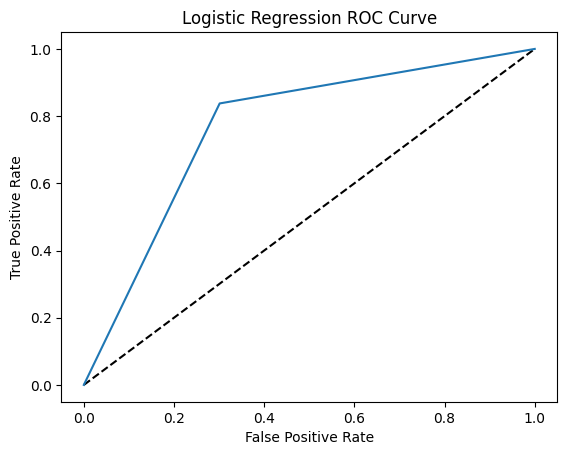

In [67]:
from sklearn.metrics import roc_curve
y_pred_prob = boosting.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

# XG Boost

In [68]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(seed = 42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
#cross validation
cv_results = cross_val_score(xgb_model, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
xgb_model.score(X_test, y_test)
print(f'Test Data: \n {xgb_model.score(X_test, y_test)}')

Cross Validation: 
0.7870353191781764
Test Data: 
 0.8619909502262444


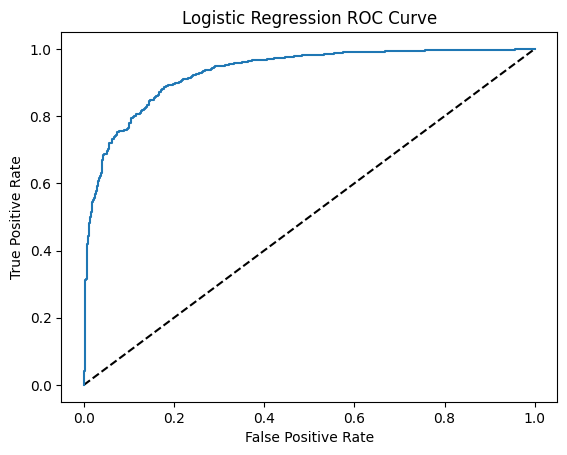

In [70]:
from sklearn.metrics import roc_curve
y_pred_prob = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

### Less Variables in Prediction
---
---
---

In [71]:
X_no_ions = X[['m3_s', 'EC_mS_cm', 'pH', 'TSS_ppm']]
X_train, X_test, y_train, y_test = train_test_split(X_no_ions, y, test_size = 0.3, random_state=42)

### Multiple Logistic Regression - No ions

In [72]:
logreg = LogisticRegression(class_weight={0:0.5, 1:0.5}, random_state=42)
cv_results = cross_val_score(logreg, X, y, cv = 60)
logreg.fit(X_train, y_train)
print(logreg.score(X_test, y_test))
print(np.mean(cv_results))

0.7341628959276018
0.79297052154195


In [73]:
pd.concat([pd.DataFrame(logreg.coef_).transpose(), pd.DataFrame(logreg.feature_names_in_)], axis = 1)
#list(logreg.feature_names_in_)]

,0,0
0,-0.134254,m3_s
1,0.104995,EC_mS_cm
2,0.176062,pH
3,6.884249,TSS_ppm


In [74]:
logreg.intercept_

array([1.21670784])

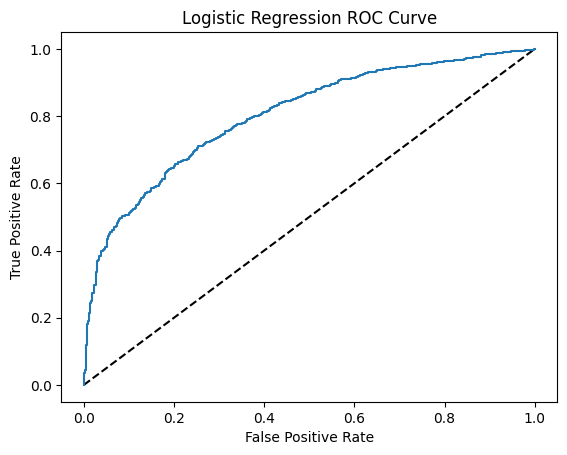

In [75]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

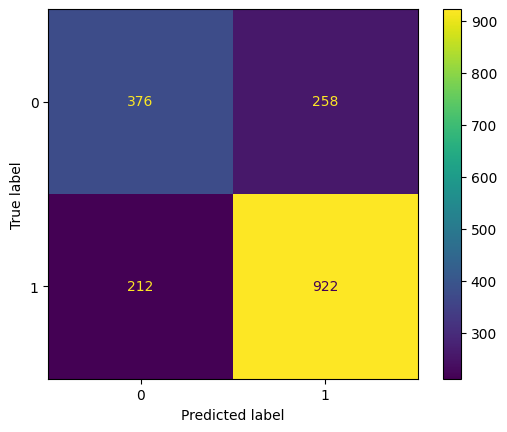

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(X_test))).plot()
plt.show()

### Random Forest - no ions

In [77]:
rf = RandomForestClassifier(n_estimators=10, class_weight={0:0.5, 1:0.5}, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.5, 1: 0.5}, n_estimators=10,
                       random_state=42)

In [78]:
#cross validation
cv_results = cross_val_score(rf, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
rf.score(X_test, y_test)
print(f'Test Data: \n {rf.score(X_test, y_test)}')

Cross Validation: 
0.7778567992853707
Test Data: 
 0.7449095022624435


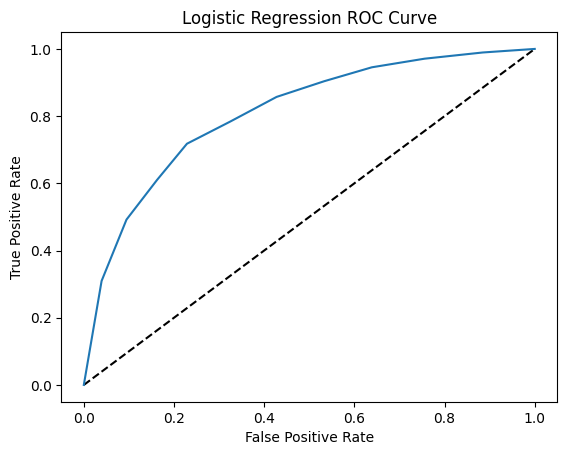

In [79]:
from sklearn.metrics import roc_curve
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

### Bagging - no ions

In [80]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0:0.5, 1:0.5}, random_state=42), n_estimators=10)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                      1: 0.5},
                                                        random_state=42))

In [81]:
#cross validation
cv_results = cross_val_score(bagging, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
bagging.score(X_test, y_test)
print(f'Test Data: \n {bagging.score(X_test, y_test)}')

Cross Validation: 
0.7840153233010376
Test Data: 
 0.7460407239819005


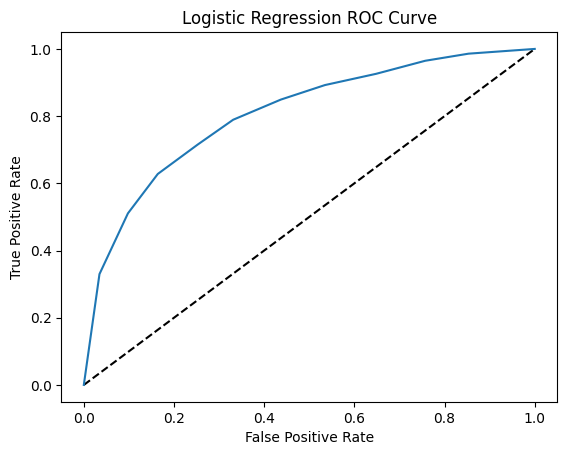

In [82]:
from sklearn.metrics import roc_curve
y_pred_prob = bagging.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

### Boosting - No ions

In [83]:
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0:0.5, 1:0.5}, random_state=42), n_estimators=10)
boosting.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.5,
                                                                       1: 0.5},
                                                         random_state=42),
                   n_estimators=10)

In [84]:
#cross validation
cv_results = cross_val_score(boosting, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
boosting.score(X_test, y_test)
print(f'Test Data: \n {boosting.score(X_test, y_test)}')

Cross Validation: 
0.7339380196523052
Test Data: 
 0.6923076923076923


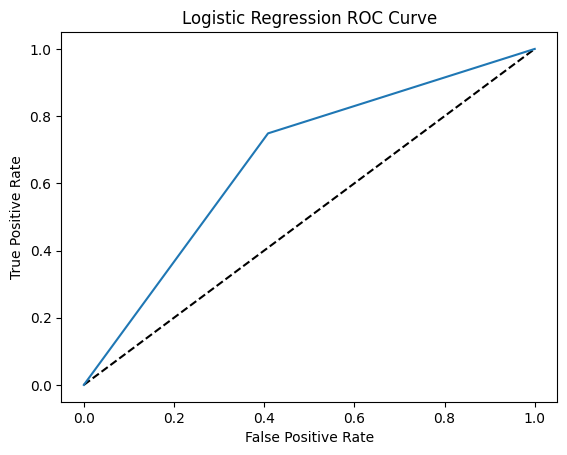

In [85]:
from sklearn.metrics import roc_curve
y_pred_prob = boosting.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

### XG Boost No ions

In [86]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(seed = 42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [87]:
#cross validation
cv_results = cross_val_score(xgb_model, X, y, cv = 60, scoring = 'accuracy')
print(f'Cross Validation: \n{np.mean(cv_results)}')

# Test Data
xgb_model.score(X_test, y_test)
print(f'Test Data: \n {xgb_model.score(X_test, y_test)}')

Cross Validation: 
0.7870353191781764
Test Data: 
 0.7579185520361991


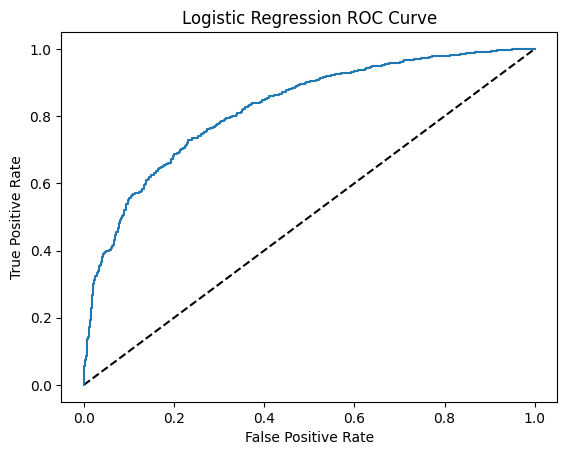

In [88]:
from sklearn.metrics import roc_curve
y_pred_prob =xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

## E. Data Summary and Implications

### Results
Multiple logistic regression provides frequently accurate predictions for the data sets provided. The model has poor predictability in a general use case. 
- Original Model
	- pseudo R<sup>2</sup> = 0.3634
	- accuracy = 75.28%
- Lean Model 
  - pseudo R<sup>2</sup> = 0.2017
  - accuracy = 75.28%
  - **Limited Variables**: m3_s, EC_mS_cm, pH, TSS_ppm


### Limitations
- Multiple logistic regression 
	- Assumes a linear relationship between the phosphorous violations and the explanatory variables
	- Non-linear models had higher accuracy scores
- Only 4 variables can be used for realistic predictions
	- Flow rates, electrical conductivity, pH, total suspended solids
	- Total suspended solids had the highest coefficient (ci) in the prediction model
- Data Quality
	- Small record count for model development: 
		- 5893 total records (4125 records for 70% training data)
		- More data is better (7000 record minimum recommended for this analysis)
	- Bias in data
		- Canals only measured during harvest season
		- Canals shut off in winter months (frost damage)
		- Class weights were set in the models. 
			- 50% weight False
			- 50% weight True

### Proposed Actions: Enhance the Classification Model
- Improved Multiple Logistic Regression
	- Run a model using the 15 statistically significant predictor variables (Remove Zinc and Sodium)
	- Observe accuracy and pseudo R<sup>2</sup> (predictability)
- Ensemble Modeling
	- combines multiple models to improve accuracy and model stability
- Deep Learning Models
	- As time passes, more data records will be collected
	- After tens of thousands of records are collected, a deep learning neural network can be attempted on the lean training data
- Flag anomalies as prediction accuracy increases
### Proposed Actions: Linear Regression
- Multiple Linear Regression
  - Like multiple logistic regression
  - Outputs a numerical phosphorous value (continuous value)
  - Conditional logic can be used to ID violations: **phosphorous levels > 0.075 ppm**

### Proposed Actions: New Calculation
- **Variables**: site locations, timestamps, flow rates, phosphorous concentrations
- **Convert the units**: 1ppm = 1mg/L, 1 m<sup>3</sup>/s = 1000 L/s
- Generate an equation to calculate the daily load of phosphorous entering the Snake River 
- Ensure no site locations overlap geographically, use the site locations closest to the river
 
**<ins>Proposed Equation</ins>**
- **Phosphorus (mg/L) x Flow Rate (L/s) = mass rate (mg/s)**
  - Derive the weight and determine the daily phosphorous inflow of all measured waterways

### Expected Benefits
- Fishing is a big income stream for Idaho!
- $7.8 billion in consumer spending<sup>8</sup>
- $2.3 billion in wages and salaries<sup>8</sup>

- Phosphorous pollution has $50 million dollar per year annual consequences<sup>9</sup>
- Contributing to research at the USDA

## F. Sources
1. University of California Museum of Paleontology. (2020, September 10). _Phosphorus_. Understanding Global Change. https://ugc.berkeley.edu/background-content/phosphorus/.
2. Raven, J. A. (2013). RNA function and phosphorus use by photosynthetic organisms. _Frontiers in Plant Science_, 4. https://doi.org/10.3389/fpls.2013.00536.
3. USDA. (2023, March 16). Conservation effects assessment project (CEAP). Natural Resources Conservation Service. https://www.nrcs.usda.gov/ceap.
4. Sadler, J., Steiner, J., James, D., Vandenberg, B., Wilson, G., Obrecht, J., Oster, T., Ross, J. D., Chen, J.-S., Cole, K., Hatfield, J., & Anderson, D. (2022, June 10). Stewards - a data delivery application for the USDA/ars conservation effects assessment project: AG data commons. STEWARDS - A data delivery application for the USDA/ARS Conservation Effects Assessment Project | Ag Data Commons. https://data.nal.usda.gov/dataset/.
5. USDA. (n.d.). Soil Tech note 15A- cation exchange capacity. Natural Resources Conservation Service. https://www.nrcs.usda.gov/conservation-basics/conservation-by-state/illinois/soil-tech-note-15a-cation-exchange-capacity.
6. IDEQ, The Middle Snake River Watershed Management Plan, phase 1 TMDL, total phosphorus 36 (1997). Twin Falls, ID; Division of Environmental Quality. 
7. Bowne-Anderson, H.(n.d.). Machine Learning with scikit-learn [MOOC]. DataCamp. https://app.datacamp.com/learn/courses/machine-learning-with-scikit-learn. 
8. Idaho Wildlife Federation. (n.d.). Public lands. https://idahowildlife.org/public-lands.
9. U.S. National Office for Harmful Algal Blooms. (n.d.). Socio-economic impacts. Harmful Algae. https://hab.whoi.edu/impacts/impacts-socioeconomic/.